In [1]:
from PIL import Image
import numpy as np
import glob
import os
import visualPercepUtils as vpu
import matplotlib.pyplot as plt

In [2]:
path_input = './imgs-P1/'
path_output = './imgs-out-P1/'
bAllFiles = True
bAllTests = False
bSaveResultImgs = True
nameTests = {'testHistEq': "Histogram equalization",
             'testBrightenImg': 'Brighten image',
             'testDarkenImg': 'Darken image'}
suffixFiles = {'testHistEq': '_heq',
               'testBrightenImg': '_br',
               'testDarkenImg': '_dk'}

if bAllFiles:
    files = glob.glob(path_input + "*.pgm")
else:
    files = [path_input + 'iglesia.pgm'] # iglesia,huesos

if bAllTests:
    tests = ['testHistEq', 'testBrightenImg', 'testDarkenImg']
else:
    tests = ['testBrightenImg']

In [3]:
def histeq(im, nbins=256):
    imhist, bins = np.histogram(im.flatten(), list(range(nbins)), density=False)
    cdf = imhist.cumsum() # cumulative distribution function (CDF) = cummulative histogram
    factor = 255 / cdf[-1]  # cdf[-1] = last element of the cummulative sum = total number of pixels)
    im2 = np.interp(im.flatten(), bins[:-1], factor*cdf)
    return im2.reshape(im.shape), cdf

def darkenImg(im,p=2):
    return (im ** float(p)) / (255 ** (p - 1)) # try without the float conversion and see what happens

def brightenImg(im,p=2):
    return np.power(255.0 ** (p - 1) * im, 1. / p)  # notice this NumPy function is different to the scalar math.pow(a,b)

def testDarkenImg(im):
    im2 = darkenImg(im,p=2) #  Is "p=2" different here than in the function definition? Can we remove "p=" here?
    return [im2]

def testBrightenImg(im):
    p=2
    im2=brightenImg(im,p)
    return [im2]

def testHistEq(im):
    im2, cdf = histeq(im)
    return [im2, cdf]

# Exercise 2

I decided only to replace two lines. My reasoning is that those two lines deal with the image transformation previously saving (Image.fromarray) and saving the image to disk with the final path. The other two are just valid for this specific implementation and are not a good idea to include if you want this implementation to be reusable in other code, as they deal with getting the path from the original filename.

In [4]:
def saveImg(image, path):
    pil_im = Image.fromarray(image.astype(np.uint8))  # from array to Image
    pil_im.save(path)

In [5]:
def doTests():
    print("Testing on", files)
    for imfile in files:
        im = np.array(Image.open(imfile).convert('L'))  # from Image to array
        for test in tests:
            out = eval(test)(im)
            im2 = out[0]
            vpu.showImgsPlusHists(im, im2, title=nameTests[test])
            if len(out) > 1:
                vpu.showPlusInfo(out[1],"cumulative histogram" if test=="testHistEq" else None)
            if bSaveResultImgs:
                dirname, basename = os.path.dirname(imfile), os.path.basename(imfile)
                fname, fext = os.path.splitext(basename)
                #print(dname,basename)
                saveImg(im2, path_output + '//' + fname + suffixFiles[test] + fext)

Testing on ['./imgs-P1/iglesia.pgm', './imgs-P1/huesos.pgm', './imgs-P1/cabeza.pgm']
4 None None


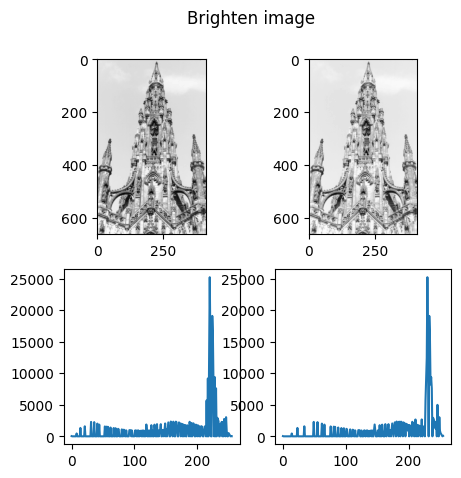

4 None None


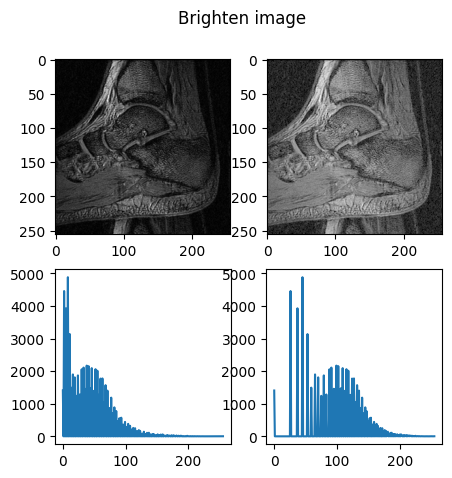

4 None None


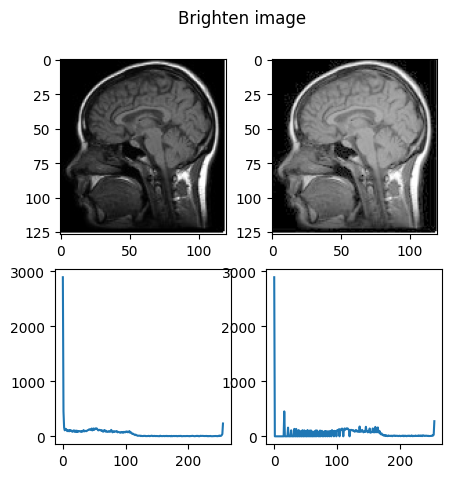

In [6]:
doTests()

# Exercise 3

There is no need to modify the functions because of broadcasting.

In [7]:
im = np.array(Image.open('./imgs-P1/girl.ppm'))

In [8]:
def darkenImg(im,p=2):
    return ((im ** float(p)) / (255 ** (p - 1))).astype('uint8')

def brightenImg(im,p=2):
    return np.power(255.0 ** (p - 1) * im, 1. / p).astype('uint8')

In [9]:
im2 = brightenImg(im)
im3 = darkenImg(im2)

### Brighten the image

4 None None


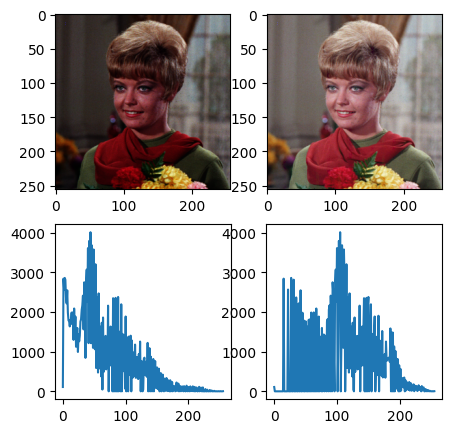

In [10]:
vpu.showImgsPlusHists(im, im2)

### Darken the image

4 None None


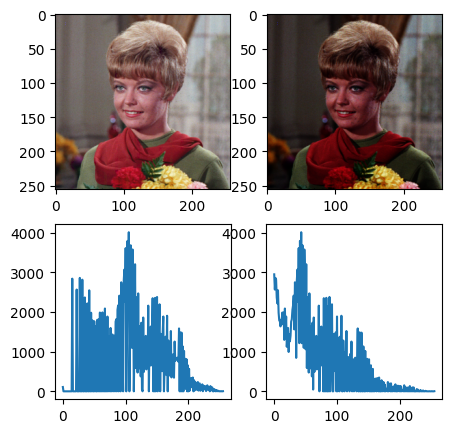

In [11]:
vpu.showImgsPlusHists(im2, im3)

# Exercise 4

This function creates a mask with a checker pattern and then applies the inversion to the pixels selected by such mask. The first implementation is the one I did by myself at first. The second and third are improvements after the teacher told me to try to use `np.meshgrid`. I found two different ways of doing the same thing. The first implementation is not what the exercise asks, instead of dividing the image in $m \times n$ cells it creates a checkerboard pattern with cells of size $ m \times n$.

In [12]:
def checkBoardImg(im, m, n):
    shape = im.shape
    im2 = im.copy()
    horizontal = np.block([np.tile(np.repeat(np.array([-1,1]), n),shape[0]//(2*n)), np.repeat(np.array([-1,1]), n)[:shape[0]%(2*n)]])
    vertical = np.block([np.tile(np.repeat(np.array([1,-1]), m),shape[1]//(2* m)), np.repeat(np.array([1,-1]), m)[:shape[1]%(2*m)]])
    mask = vertical[:,np.newaxis] * horizontal
    im2[mask<0] = 255 - im2[mask<0]
    return im2

In [13]:
def checkBoardImg2(im, m, n):
    shape = im.shape
    im2 = im.copy()
    a = np.zeros((m+1, n+1))
    a[1::2, ::2] = 1
    a[::2, 1::2] = 1
    mask = np.kron(a, np.ones((shape[0]//m, shape[1]//n)))[:shape[0]:,:shape[1]:]
    im2[mask==1] = 255 - im2[mask==1]
    return im2

In [14]:
def checkBoardImg3(im, m, n):
    shape = im.shape
    im2 = im.copy()
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    cell_x = x // (shape[1] // n)
    cell_y = y // (shape[0] // m)
    mask = (cell_x + cell_y) % 2
    im2[mask==1] = 255 - im2[mask==1]
    return im2

In [15]:
im2 = checkBoardImg3(im,5,3)

1 None None


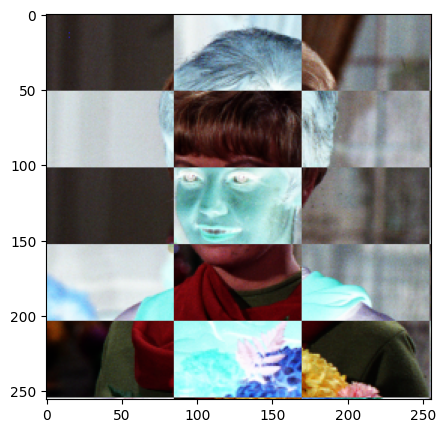

In [16]:
import matplotlib.pyplot as plt
vpu.showInGrid([im2])

# Exercise 5

In [17]:
im = np.array(Image.open('./imgs-P1/iglesia.pgm'))

Split each image using `np.array_split` twice. Once for each dimension. Then calculate all the histograms and plot them.

In [29]:
def multiHist(im, n, nbins=256):
     hists = []
     for i in range(n):
          quad = [M for SubA in np.array_split(im, i + 1, axis=0) for M in np.array_split(SubA, i + 1, axis=1)]
          hists += [np.histogram(subIm.flatten(), nbins, density=False)[0] for subIm in quad]
     return hists

In [30]:
hists = multiHist(im, 2, 3)
hists

[array([ 25837,  53944, 193375]),
 array([ 1823,  3816, 62753]),
 array([ 3842,  7759, 56791]),
 array([ 8995, 19490, 39701]),
 array([10914, 21888, 35384])]

5 None None


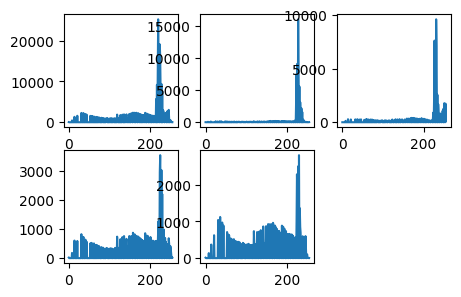

In [33]:
hists = multiHist(im, 2)
vpu.showInGrid(hists)

# Exercise 6

Had some trouble with this exercise. I interpreted it as a different kind of problem and instead of solving a simple two unknows equation system I divided the space between [l0, l1] so the function could take values in that range but without explicitly making the equation to take only values in that range.

In [22]:
def expTransf(alpha, n, l0, l1, bInc=True):
    input = np.linspace(l0, l1, n)
    alpha = float(alpha)
    a = (l0 - l1) / (np.exp(-alpha * l0**2) - np.exp(-alpha * l1**2))
    b = l0 - a * np.exp(-alpha * l0**2)
    if bInc:
        return a * np.exp(-alpha * input**2) + b
    return (a * np.exp(-alpha * input**2) + b)[::-1]

Plots showing different ranges and alpha values

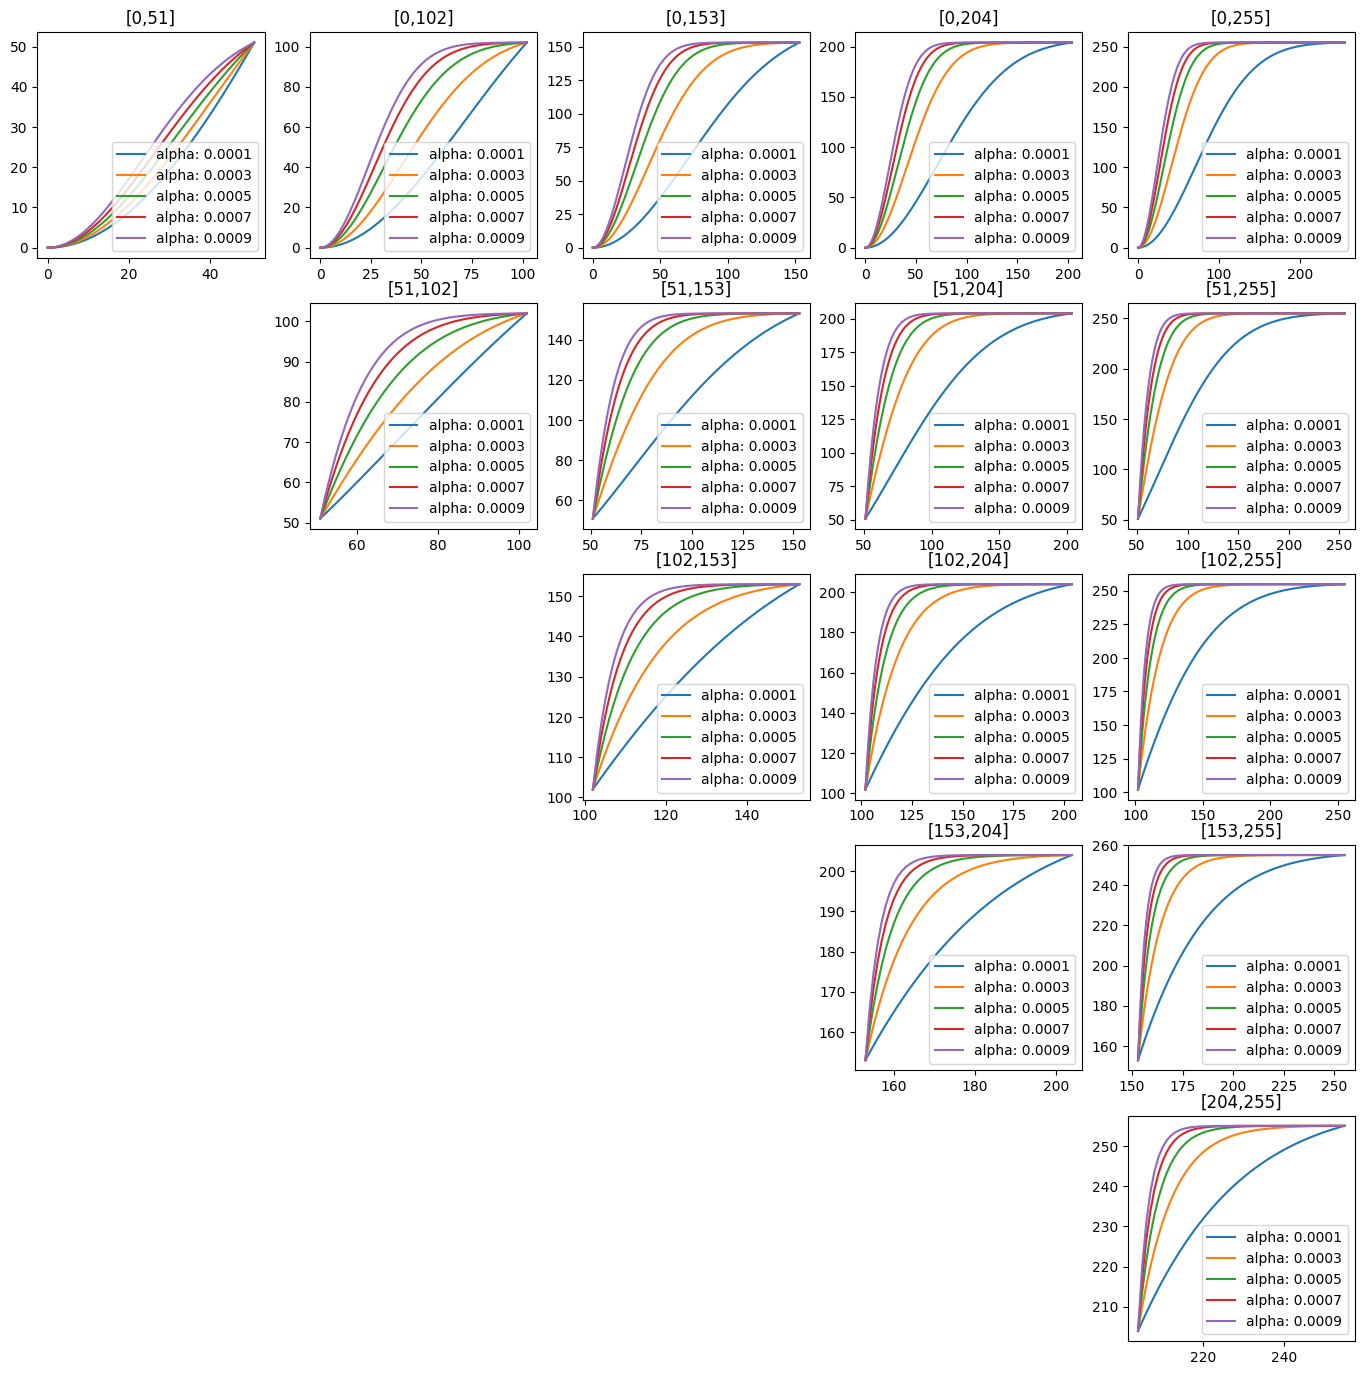

In [23]:
fig = plt.figure(figsize=(17, 17))
for i in range(0,255, 51):
    for j in range(i+51, 256, 51):
        ax = fig.add_subplot(5, 5, i//51*5+j//51)
        for alpha in range(1, 10, 2):
            x =  np.linspace(i,j,j-i+1)
            y = expTransf(alpha/10000,j-i+1,i,j)
            plt.plot(x,y, label = f'alpha: {alpha/10000}')
            ax.set_title(f'[{i},{j}]')
            ax.legend(loc='lower right')
plt.show()

And then transform an image to test the transformation.

In [24]:
def transfImage(im, f):
    transf = f.astype('uint8')
    l0 = min(transf)
    l1 = max(transf)
    im2 = im.copy()
    im2[(im2>=l0) & (im2 <= l1)] = transf[im2[(im2>=l0) & (im2 <= l1)] - l0]
    return im2

4 None None


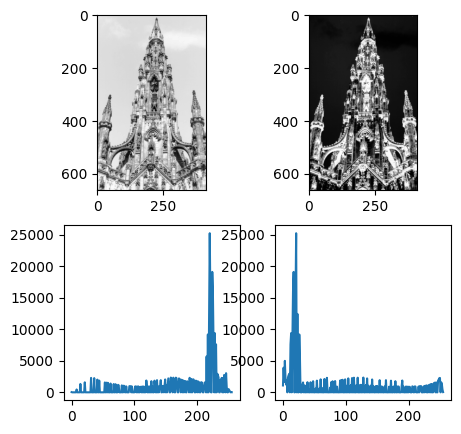

In [25]:
im2 = transfImage(im, expTransf(0.0001,256,0,255, False))
vpu.showImgsPlusHists(im, im2)